<a href="https://colab.research.google.com/github/rupali-p/recycling-app/blob/tammy%2Fml-experiments/Tammy_ML_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Try create a simple resin code identification model
Based on https://www.kaggle.com/code/cheedcheed/fine-tuning-mobilenet-for-resin-id-codes

- Used the Free Google Colab GPU to train model ~15 minutes
- Recommend uploading training data zip and then unzipping file
- Used Kaggle Plastic Recycling code dataset https://www.kaggle.com/datasets/piaoya/plastic-recycling-codes

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [97]:
# !unzip resin_codes_zip.zip

In [98]:
img_height, img_width = IMG_SIZE = (200, 200)
batch_size = 32

data_dir = "seven_plastics"

## Load images

In [178]:
from sklearn.model_selection import train_test_split

In [179]:
# Training - 70%, Val - 10%, Test - 20%
validation_split = 0.3
shuffle_value = True
train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=shuffle_value
  )

Found 685 files belonging to 8 classes.
Using 480 files for training.


In [180]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=shuffle_value
  )

Found 685 files belonging to 8 classes.
Using 205 files for validation.


In [153]:
# Get number of batches of data available in the validation set
val_batches = tf.data.experimental.cardinality(val_ds)

test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

In [102]:
# List the classes

class_names = train_ds.class_names
class_names

['1_polyethylene_PET',
 '2_high_density_polyethylene_PE-HD',
 '3_polyvinylchloride_PVC',
 '4_low_density_polyethylene_PE-LD',
 '5_polypropylene_PP',
 '6_polystyrene_PS',
 '7_other_resins',
 '8_no_plastic']

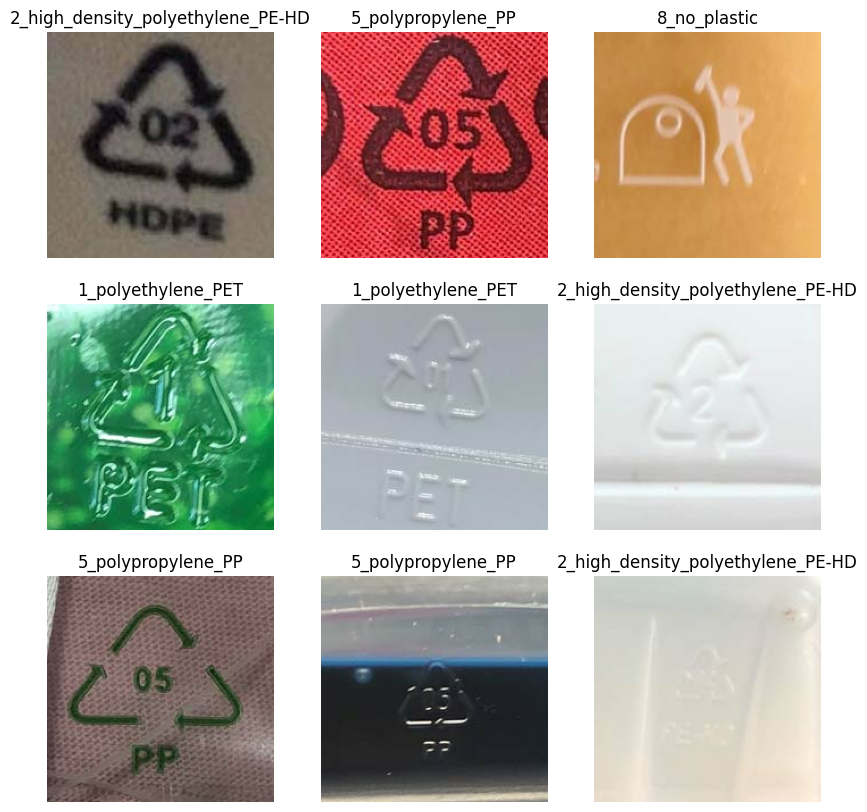

In [103]:
# Examine the training data

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [104]:
# Prefetch images to memory, to speed up training

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

## Data Augumentation

In [105]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [106]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Use MobileNet for transfer learning

In [107]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [108]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [109]:
# Keep the pre-trained weights, set this to true to retrain the whole model.
base_model.trainable = False

In [110]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [111]:
num_classes = len(class_names)

prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 8)


## Build the Model

In [112]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [113]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(), # lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [114]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 200, 200, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 200, 200, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [115]:
initial_epochs = 300

loss0, accuracy0 = model.evaluate(val_ds)

3/3 [==============================] - 2s 36ms/step - loss: 2.5944 - accuracy: 0.0649


In [116]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/300
15/15 [==============================] - 5s 60ms/step - loss: 2.2103 - accuracy: 0.2000 - val_loss: 1.8587 - val_accuracy: 0.3377
Epoch 2/300
15/15 [==============================] - 1s 59ms/step - loss: 1.7204 - accuracy: 0.3396 - val_loss: 1.6115 - val_accuracy: 0.4026
Epoch 3/300
15/15 [==============================] - 1s 55ms/step - loss: 1.4850 - accuracy: 0.4500 - val_loss: 1.8324 - val_accuracy: 0.3506
Epoch 4/300
15/15 [==============================] - 1s 56ms/step - loss: 1.3306 - accuracy: 0.4938 - val_loss: 1.4978 - val_accuracy: 0.4156
Epoch 5/300
15/15 [==============================] - 1s 57ms/step - loss: 1.2744 - accuracy: 0.5271 - val_loss: 1.5798 - val_accuracy: 0.4416
Epoch 6/300
15/15 [==============================] - 1s 56ms/step - loss: 1.1919 - accuracy: 0.5750 - val_loss: 1.4058 - val_accuracy: 0.4286
Epoch 7/300
15/15 [==============================] - 1s 58ms/step - loss: 1.1378 - accuracy: 0.5729 - val_loss: 1.5318 - val_accuracy: 0.4156
Epoch 

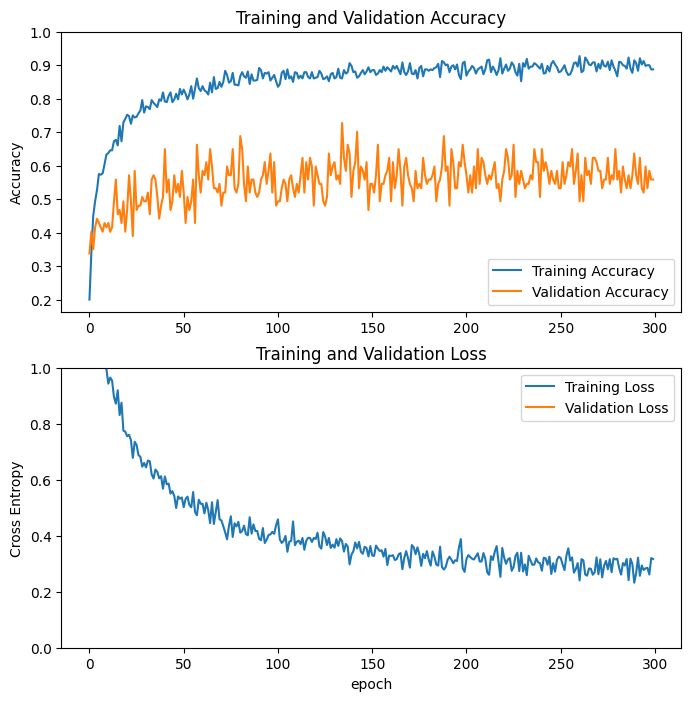

In [117]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [118]:
# Input data examination
import os
from collections import Counter
import PIL
import PIL.Image

for dirname, _, filenames in os.walk(data_dir):
    c = Counter()

    for filename in filenames:
        with PIL.Image.open(str(os.path.join(dirname, filename))) as im:
            c.update([im.size])

    print(os.path.basename(dirname))

    for key, value in c.items():
        print(key, value)


seven_plastics
2_high_density_polyethylene_PE-HD
(200, 200) 72
(199, 200) 4
4_low_density_polyethylene_PE-LD
(200, 200) 89
(200, 199) 1
1_polyethylene_PET
(200, 200) 110
(199, 200) 6
(200, 199) 5
8_no_plastic
(200, 200) 71
(200, 130) 1
(180, 200) 1
(200, 199) 2
(199, 200) 1
(150, 200) 1
(200, 176) 1
(200, 192) 1
6_polystyrene_PS
(200, 200) 37
(199, 200) 1
(200, 199) 1
5_polypropylene_PP
(200, 200) 171
(200, 199) 12
(200, 198) 1
(199, 200) 8
3_polyvinylchloride_PVC
(200, 200) 24
7_other_resins
(199, 200) 3
(200, 200) 58
(198, 200) 2
(200, 199) 1


## Evaluate on test data

In [319]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay
)

### Functions
In future, can put these in a separate file so they can be unit tested.

In [320]:
def get_predicted_labels_and_probabilities(predictions: list[list]) -> tuple[list, list]:
  """Gets the label and probabilities of the largest prediction for each output list

  Args:
    predictions: The predictions

  Returns:
    The predicted labels followed by the probabilities
  """

  probabilities = []
  labels = []

  for prediction in predictions:
    score = tf.nn.softmax(prediction)
    probabilities.append(np.max(score))
    labels.append(np.argmax(score))

  return labels, probabilities

In [321]:
def plot_histogram(
    data: list,
    bins: int = None,
    title: str = "Histogram",
    x_label: str = "Categories",
    y_label: str = "Count"
  ) -> None:
  """Plots a histogram of the given data

  Args:
    data: The data to plot
    bins: number of histogram bins

  Returns:
    Nothing
  """

  plt.hist(data, edgecolor="black", bins=bins)
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.show()

In [322]:
def get_accuracy(y_true: list, y_pred: list) -> float:
  """Gets the accuracy score.

  Args:
    y_true: List of true values
    y_pred: List of predicted values

  Returns:
    The accuracy score
  """

  return accuracy_score(y_true, y_pred)

In [323]:
def show_confusion_matrix(y_true: list, y_pred: list) -> None:
  """Plots the confusion matrix

  Args:
    y_true: The true values
    y_pred: The predicted values

  Returns:
    None
  """

  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(cm)
  disp.plot()

In [324]:
# Examine the test data

# image_batch, label_batch = next(iter(test_ds))

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].numpy().astype("uint8"))
#   label = label_batch[i]
#   plt.title(class_names[label])
#   plt.axis("off")

In [325]:
unbatched_test_ds = test_ds.unbatch()

images = [image for image, label in unbatched_test_ds.as_numpy_iterator()]
y_true = [label for image, label in unbatched_test_ds.as_numpy_iterator()]

predictions = model.predict(test_ds)

4/4 [==============================] - 0s 42ms/step


In [326]:
# Can see the predictions show all categories for each input (the output layer)
[p for p in predictions[:3]]

[array([ -7.196127 , -10.660174 ,  -9.561927 ,  -5.656842 ,  -6.7458153,
        -11.440923 ,  -6.2932153,  15.796633 ], dtype=float32),
 array([ -6.369887 , -13.9822855, -13.829394 ,  -1.4690754,  -3.527238 ,
         -6.3020825,  -1.1025128,  -5.0548835], dtype=float32),
 array([ -1.5383191,  -2.9723766, -11.765085 ,  -1.8617059,   1.297221 ,
         -3.9861693,  -1.4756165,  -6.370797 ], dtype=float32)]

In [327]:
# Applying softmax to the values normalises them to lie between 0 and 1
[tf.nn.softmax(p) for p in predictions[:3]]

[<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([1.0336449e-10, 3.2356017e-12, 9.7032651e-12, 4.8180770e-10,
        1.6215831e-10, 1.4821069e-12, 2.5497704e-10, 1.0000000e+00],
       dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([2.8468776e-03, 1.4071690e-06, 1.6396307e-06, 3.8261691e-01,
        4.8855729e-02, 3.0466027e-03, 5.5202693e-01, 1.0603945e-02],
       dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([4.9601145e-02, 1.1821931e-02, 1.7949959e-06, 3.5896037e-02,
        8.4518361e-01, 4.2894729e-03, 5.2810840e-02, 3.9516005e-04],
       dtype=float32)>]

In [328]:
# Extract the predicted labels based on highest output neuron
y_pred, y_probabilities = get_predicted_labels_and_probabilities(predictions)

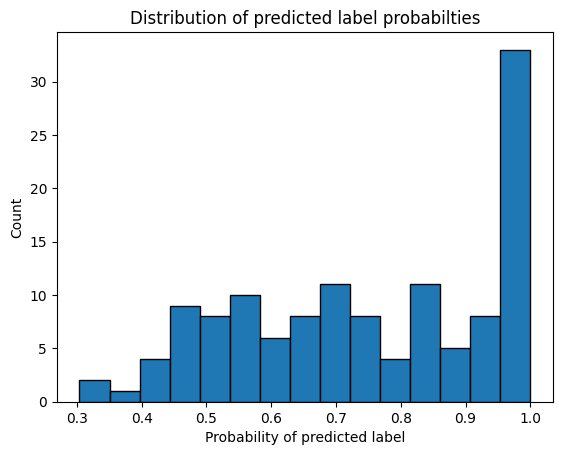

In [329]:
plot_histogram(
    data=y_probabilities,
    bins=15,
    title="Distribution of predicted label probabilties",
    x_label="Probability of predicted label",
    y_label="Count"
)

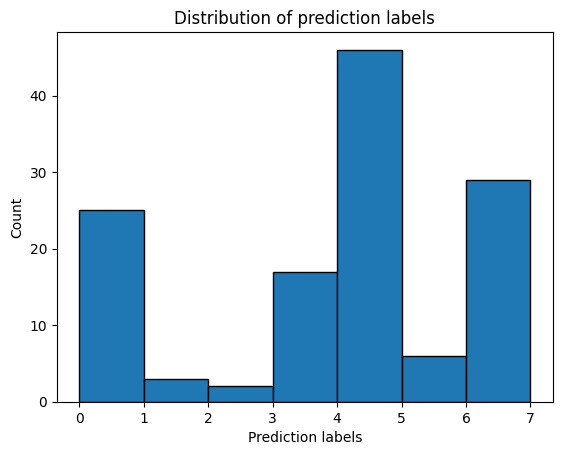

In [330]:
plot_histogram(
    data=y_pred,
    bins=7,
    title="Distribution of prediction labels",
    x_label="Prediction labels",
    y_label="Count"
)

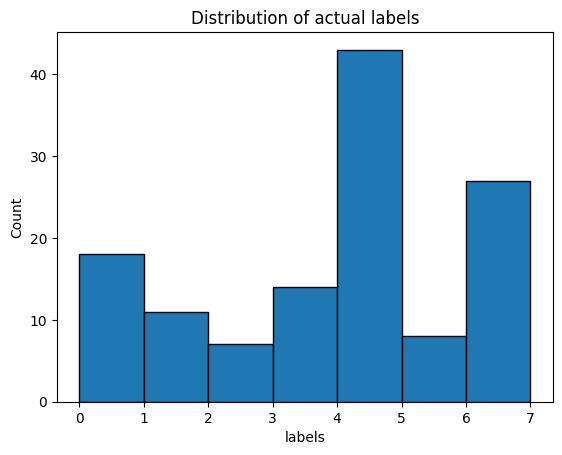

In [331]:
plot_histogram(
    data=y_true,
    bins=7,
    title="Distribution of actual labels",
    x_label="labels",
    y_label="Count"
)

In [334]:
get_accuracy(y_true, y_pred)

0.15625

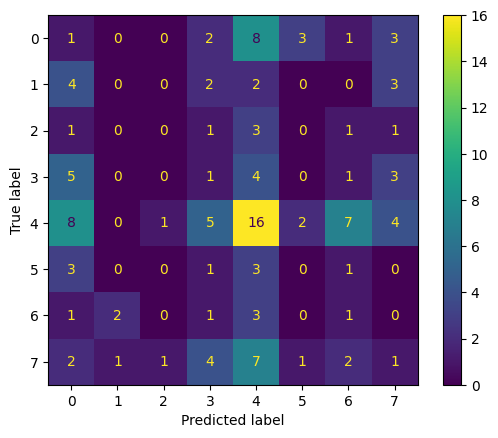

In [332]:
show_confusion_matrix(y_true, y_pred)